***
# <font color=red>Chapter 6: MedTALN inc.'s Case Study - Fine-funed Healthcare NER Models Evaluation</font>
<p style="margin-left:10%; margin-right:10%;">by <font color=teal> John Doe (typica.ai) </font></p>

***


## Overview: 

This notebook guides you through the process of evaluating the fine-funed Healthcare NER Models.

In this notebook we will evaluate the best chekpoint of the fine-tuned models that were trained using the **train_ner_models** notebook. This process will result in identifiying the best-performing model based on evaluation metrics and the test dataset.

The notebook is structured into several key steps to ensure a smooth and effective training process:

1. **Load Dataset**: We begin by loading the dataset, specifically formatted for our token classification tasks, (i.e. NER).
2. **Evaluate the Models**: We will evaluate the NER models using a HF trainer.evaluate() API. The evaluation process will result in selecting the best-performing model based on F1 score.
3. **Test the best Model**: After the evaluation , the best model will be tested on the examples that were used to select the pre-trained models.



In [7]:
!nvidia-smi

Mon Aug 26 15:46:32 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10                     Off |   00000000:00:04.0 Off |                    0 |
|  0%   43C    P0             59W /  150W |    2729MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Install the hugging face transformers library (install once for the conda env.).

%%capture
!pip install transformers -U
!pip install accelerate -U
!pip install datasets
!pip install evaluate
!pip install seqeval

Filters out warnings

In [8]:
import warnings
warnings.filterwarnings('ignore')

## Initialization

### Load the training dataset

In [9]:
from datasets import load_from_disk

healthcare_ner_dataset = load_from_disk('/home/datascience/buckets/training-datasets-bkt/healthcare_ner_dataset_v1.2.0')
healthcare_ner_dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 6750
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1687
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 563
    })
})

### Define helper functions

In [12]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

## Evaluate

Evaluate test split using the HF API trainer.evaluate()

### Load best checkpoints

In [13]:
import os
from transformers.trainer_callback import TrainerState

def get_best_checkpoint(root_dir):
    best_checkpoints = {}

    # Walk through all directories and subdirectories
    for root, dirs, files in os.walk(root_dir):
        # Filter directories that start with "healthcare_ner"
        relevant_dirs = [d for d in dirs if d.startswith("healthcare_ner")]

        for dir_name in relevant_dirs:
            model_dir = os.path.join(root, dir_name)
            for sub_root, sub_dirs, sub_files in os.walk(model_dir):
                ckpt_dirs = [d for d in sub_dirs if d.startswith('checkpoint')]
                if ckpt_dirs:
                    ckpt_dirs = sorted(ckpt_dirs, key=lambda x: int(x.split('-')[1]))
                    last_ckpt = ckpt_dirs[-1]

                    state = TrainerState.load_from_json(f"{sub_root}/{last_ckpt}/trainer_state.json")
                    best_model_checkpoint = state.best_model_checkpoint
                    #temp fix
                    best_model_checkpoint = best_model_checkpoint.replace('training_local_dir', 'buckets/models-ckpt-bkt')
                    
                    best_checkpoints[sub_root] = best_model_checkpoint

    return best_checkpoints

root_dir = "/home/datascience/buckets/models-ckpt-bkt/models"

best_models_checkpoints = get_best_checkpoint(root_dir)

for model_dir, best_ckpt in best_models_checkpoints.items():
    print(f"Best checkpoint for model in {model_dir}: {best_ckpt}")


Best checkpoint for model in /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-4GB: /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-4GB/checkpoint-1688
Best checkpoint for model in /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-4GB-CP-PubMedBERT: /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-4GB-CP-PubMedBERT/checkpoint-2532
Best checkpoint for model in /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-7GB: /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-7GB/checkpoint-1688
Best checkpoint for model in /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-abazoge/DrBERT-4096: /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-abazoge/DrBERT-4096/checkpoint-1688
Best checkpoint for model in /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-almanach/camembert-bio-base: 

### Evalute all the models best checkpoints

Loop on the fine-tuned model best checkpoints and evaluate  

In [14]:
from transformers import AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import DataCollatorForTokenClassification
import evaluate
from datasets import load_metric
from torch.utils.data import DataLoader
import numpy as np

metric = evaluate.load("seqeval")

eval_dir = "/home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner/evaluation"

# Initialize TrainingArguments (to configure the evaluation)
evaluation_args = TrainingArguments(
    output_dir=f"{eval_dir}/eval_results",
    per_device_eval_batch_size=8,
    logging_dir="{eval_dir}/eval_logs",
    do_train=False,  # We are only evaluating
    do_eval=True,
)


label_names = healthcare_ner_dataset["test"].features["ner_tags"].feature.names

# Evaluate each model and collect the results
model_results = {}

for model_dir, model_checkpoint in best_models_checkpoints.items():

    if model_checkpoint is not None:

      print(f"Evaluating model checkpoint : {model_checkpoint}")

      # Load the model and tokenizer
      model = AutoModelForTokenClassification.from_pretrained(model_checkpoint)
      tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
      data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

      test_tokenized_datasets = healthcare_ner_dataset["test"].map(
          tokenize_and_align_labels,
          batched=True,
          remove_columns=healthcare_ner_dataset["test"].column_names,
      )

      eval_dataloader = DataLoader(
          test_tokenized_datasets, collate_fn=data_collator, batch_size=8
      )

      # Initialize the Trainer
      trainer = Trainer(
          model=model,
          args=evaluation_args,
          eval_dataset=test_tokenized_datasets,#eval_dataset=test_dataset,
          data_collator=data_collator,   # Include the data collator here
          compute_metrics=compute_metrics,
          tokenizer=tokenizer,
          )

      # Evaluate the model
      results = trainer.evaluate()
      model_results[model_checkpoint] = results


Evaluating model checkpoint : /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-4GB/checkpoint-1688


Detected kernel version 5.4.17, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


[2024-08-26 16:16:55,437] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Evaluating model checkpoint : /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-4GB-CP-PubMedBERT/checkpoint-2532


Detected kernel version 5.4.17, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Evaluating model checkpoint : /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-7GB/checkpoint-1688


Detected kernel version 5.4.17, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Evaluating model checkpoint : /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-abazoge/DrBERT-4096/checkpoint-1688


Map:   0%|          | 0/563 [00:00<?, ? examples/s]

Detected kernel version 5.4.17, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


Evaluating model checkpoint : /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-almanach/camembert-bio-base/checkpoint-3376


Detected kernel version 5.4.17, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# The data you provided
data = model_results

# Extract models and their metrics
# Extract models and their metrics
models = list(data.keys())
metrics_data = [list(metrics.values()) for metrics in data.values()]
metrics_names = list(data[models[0]].keys())  # Extract metric names

# Filter out samples and steps per second metrics
metrics_names = [metric for metric in metrics_names if metric not in ['eval_model_preparation_time','eval_runtime','eval_samples_per_second', 'eval_steps_per_second']]
df = pd.DataFrame(metrics_data, index=models, columns=list(data[models[0]].keys()))[metrics_names]

df

,eval_loss,eval_precision,eval_recall,eval_f1,eval_accuracy
/home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-4GB/checkpoint-1688,0.237051,0.732680,0.721364,0.726978,0.927640
/home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-4GB-CP-PubMedBERT/checkpoint-2532,0.211613,0.789223,0.763413,0.776104,0.941356
/home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-Dr-BERT/DrBERT-7GB/checkpoint-1688,0.240774,0.731629,0.729299,0.730463,0.924297
/home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-abazoge/DrBERT-4096/checkpoint-1688,0.236985,0.728912,0.721019,0.724944,0.924297
/home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-almanach/camembert-bio-base/checkpoint-3376,0.283445,0.782905,0.775584,0.779228,0.927894


Visualizing results
You can feed in the results list above into the plot_radar() function to visualize different aspects of their performance and choose the model that is the best fit, depending on the metric(s) that are relevant to your use case:

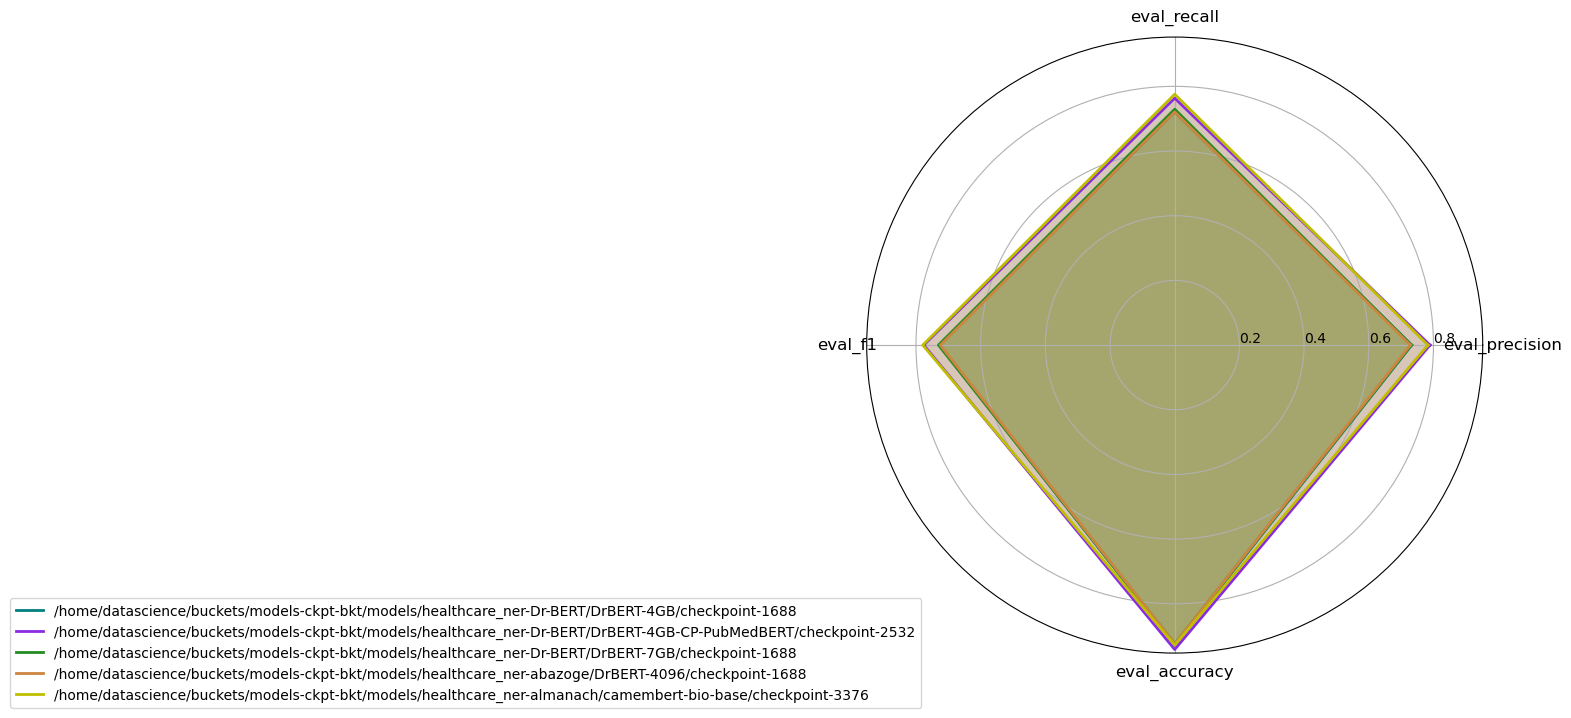

In [19]:
# Radar plot
def radar_plot(data, model_names, metrics):
    categories = metrics
    N = len(categories)

    # Calculate angle of each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    # Loop through each model's results
    for i, model_name in enumerate(model_names):
        values = data.iloc[i].tolist()
        values += values[:1]  # to close the plot
        ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name)
        ax.fill(angles, values, alpha=0.25)

    # Add labels to axes
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=12)

    # Draw one axe per variable and add labels
    ax.set_rlabel_position(0)

    # Show legend
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

# Filter out samples and steps per second metrics
metrics_names = [metric for metric in metrics_names if metric not in ['eval_loss','eval_model_preparation_time','eval_runtime','eval_samples_per_second', 'eval_steps_per_second']]
#metrics_names = [metric for metric in metrics_names if metric not in ['eval_model_preparation_time','eval_runtime','eval_samples_per_second', 'eval_steps_per_second']]
df = pd.DataFrame(metrics_data, index=models, columns=list(data[models[0]].keys()))[metrics_names]

# Plot all metrics on the radar chart
radar_plot(data=df, model_names=models, metrics=metrics_names)


### Select the best model



We can choose the best model based on the evaluation metrics. Let’s say you choose the model with the highest F1 score:

Now that we have a DataFrame df with the evaluation metrics, we can select the best model based on one of these metrics, such as F1 score:

In [20]:
from transformers import AutoTokenizer, AutoModelForTokenClassification

best_model_row = df.loc[df['eval_f1'].idxmax()]
best_model_path = best_model_row.name  # This gets the index, which is the model path

from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Load the best model and tokenizer
tokenizer = AutoTokenizer.from_pretrained(best_model_path)
model = AutoModelForTokenClassification.from_pretrained(best_model_path)

print(f"Model and Tokenizer intialized from the best performing model checkpoint:\n{best_model_path}")


Model and Tokenizer intialized from the best performing model checkpoint:
/home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner-almanach/camembert-bio-base/checkpoint-3376


## Save the best model

Save the trained healthcare NER model (version 1.0.0) and its tokenizer will to the models-ckpt-bkt bucket under the name: `/home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner_model_v1.0.0`

Using the save_pretrained method, both the model's weights and configuration files, as well as the tokenizer, are saved to this specified directory. This ensures that the model and tokenizer can be easily reloaded or shared later. 

In [24]:
# Define the directory where you want to save the model

# Modify the _name_or_path attribute
model.config._name_or_path = "healthcare_ner_model_v1.0.0"

model_save_dir = f'/home/datascience/buckets/models-ckpt-bkt/models/{model.config._name_or_path}'

# Save the model
model.save_pretrained(model_save_dir)

# Save the tokenizer
tokenizer.save_pretrained(model_save_dir)

print(f"Model and tokenizer saved to {model_save_dir}")


Model and tokenizer saved to /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner_model_v1.0.0


## Test the best model

Given the evaluation metrics in the DataFrame, the model with the best performance across precision, recall, F1, and accuracy is healthcare_ner-almanach/camembert-bio-base


### Prepare the Test Examples
We will resue the test sentences that we already used in the select_pretrained_model

In [22]:
test_examples = [
    "Le medecin donne des antibiotiques en cas d'infections des voies respiratoires."
    ,"Le médecin recommande des corticoïdes pour réduire l'inflammation dans les poumons."
    ,"Pour soulager les symptômes d'allergie, le médecin prescrit des antihistaminiques."
    ,"Pour gérer le diabète, le médecin prescrit une insulinothérapie."
    ,"Après une blessure musculaire, le patient doit suivre une physiothérapie."
    ,"En cas d'infection bactérienne, le médecin recommande une antibiothérapie."
]

test_examples

["Le medecin donne des antibiotiques en cas d'infections des voies respiratoires.",
 "Le médecin recommande des corticoïdes pour réduire l'inflammation dans les poumons.",
 "Pour soulager les symptômes d'allergie, le médecin prescrit des antihistaminiques.",
 'Pour gérer le diabète, le médecin prescrit une insulinothérapie.',
 'Après une blessure musculaire, le patient doit suivre une physiothérapie.',
 "En cas d'infection bactérienne, le médecin recommande une antibiothérapie."]

### Load and Use the Best Model:
We can now generate predictions using this dynamically selected model



In [30]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Load the best model and tokenizer from the model_save_dir
tokenizer = AutoTokenizer.from_pretrained(model_save_dir)
model = AutoModelForTokenClassification.from_pretrained(model_save_dir)

# Define the pipeline, for named entity recognition (NER) pipeline
# Set the device parameter to use GPU (0 for the first GPU, or -1 for CPU)
ner_pipeline = pipeline('token-classification', 
                        model=model, 
                        tokenizer=tokenizer, 
                        aggregation_strategy="first",
                        device=0  # Use the first GPU
                       )

print(f"pipeline initialized with model {model.config._name_or_path} from  {model_save_dir}")


pipeline initialized with model /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner_model_v1.0.0 from  /home/datascience/buckets/models-ckpt-bkt/models/healthcare_ner_model_v1.0.0


### Generate Predictions from the
Generate predictions for each test example using the best-performing model:


Running this code will print the predictions from the best-performing model in a human-readable format, allowing you to see how it labels each token in your test sentences.



In [31]:
def format_predictions(predictions):
    formatted_output = []
    for entity in predictions:
        formatted_output.append(f"Entity: {entity['word']}, Label: {entity['entity_group']}, Score: {entity['score']:.2f}")
    return "\n".join(formatted_output)

for example in test_examples:
    print(f"Input: {example}")
    predictions = ner_pipeline(example)
    formatted_output = format_predictions(predictions)
    print(formatted_output)
    print("\n")

Input: Le medecin donne des antibiotiques en cas d'infections des voies respiratoires.
Entity: antibiotiques, Label: MedicationVaccine, Score: 0.74


Input: Le médecin recommande des corticoïdes pour réduire l'inflammation dans les poumons.
Entity: corticoïdes, Label: MedicationVaccine, Score: 0.75


Input: Pour soulager les symptômes d'allergie, le médecin prescrit des antihistaminiques.
Entity: antihistaminiques., Label: MedicationVaccine, Score: 0.75


Input: Pour gérer le diabète, le médecin prescrit une insulinothérapie.
Entity: insulinothérapie., Label: MedicalProcedure, Score: 0.83


Input: Après une blessure musculaire, le patient doit suivre une physiothérapie.
Entity: physiothérapie., Label: MedicalProcedure, Score: 0.83


Input: En cas d'infection bactérienne, le médecin recommande une antibiothérapie.
Entity: antibiothérapie., Label: MedicalProcedure, Score: 0.83




This concludes this notebook.